# Intro and Setup Use Diff
These are all the libraries that are needed

In [1]:
import pandas as pd
import numpy as np
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

## Data Details

In order to capture the image and data of a black hole, we would need a telescope the size of the earth! Although we don't have one of those, the Event Horizon Telescope were still able to obtain some data about black holes by using a technology called Very Long Baseline Interferometry (VLBI). This involves having many telescope around the world. This in turn creates a virtual telescope and allows us to capture the image of the black hole's silouette. They are the only ones in the world to do so!

Most of the optics like cameras and cellphones, they don't hit a limit called the Defraction Limit. This limit is the point at which two Airy patterns are no longer distinguishable from each other and is often known as the cutoff frequence of a lens. Since EHT wants to image things that are extremely far away, they are constantly working at the Defraction limit and are limited by the physics of light.

Because of these limitations, EHT is only able to collect sparse data in the Fourier domain (rather than an actually picture image). Thus in order to obtain a picture, we must do a image reconstruction as an optimization problem in order to fill in the gaps. The data set from EHT (The Event Horizon Telescope) and from the HOPS pipeline (software from MIT), comes in multiple sets. From one data collection, we are given a hi band and low band sets, and here's why.

Suppose that the sky signal is some radio wave $Sky = \epsilon \sin(\omega t)$. The signal however is extremely small which make it hard to detect. In order to pick out this signal on earth, we use a local oscillator which generates another wave (i.e. $LO = A \sin(\omega't)$) where A is some amplitude. Once these two signals are multiplied together, we get something like so: $Sky \times LO = A \epsilon \sin(\omega t) \times \sin(\omega' t) = A \epsilon {\sin[(\omega + \omega')t] + sin [(\omega - \omega')t]}$. 

Here we have $A \epsilon$ be an amplitude such that the signals are big enough for our instruments to detect.
The $\omega + \omega'$ and $\omega - \omega'$ results in two bands which the data is taken from. Theoretically the two bands should create the same image but that is not always the case.

## Some Details about the Table

time is the time that it was taken. This time stamp is not used because we assume things are static.

T1 and T2 are the two telescopes.

U and V are the fourier location of the fourier domain. When we plot each point in the fourier domain, we should obtain something like below #HEREEE They are given in terms of lambda.

Iamp is the Amplitude of the Fourier Coefficient 

IPhase is the Phase of the Fourier Coefficient in degrees 

ISigma is the error or the noisiness of the data point

Here, we will start to preprocess the data. First we will create a class to hold the information is a more accessible manner

In [2]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

The next few cells read the data from a csv file

In [3]:
def process_data(data_df):
    """
    Processes the data in the dataframe into a coords list and data objects
    Args:
        data_df is a pandas data frame of the data
    Returns:
        a list of coordinates in u,v space
        a list of data objects
    """

    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [4]:
def read_data(filename):
    """
    reads the data from a file into a pandas dataframe
    Args:
        filename is a string that represents a csv file
    Returns:
        a pandas dataframe
    """
    df = pd.read_csv(filename)
    return df

In [5]:
df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
coords, data_list = process_data(df)
df

,#time(UTC),T1,T2,U(lambda),V(lambda),Iamp(Jy),Iphase(d),Isigma(Jy)
0,0.768056,AA,LM,1.081710e+09,-3.833722e+09,0.014292,-118.9454,0.005847
1,0.768056,AA,PV,-4.399933e+09,-4.509480e+09,0.136734,5.8638,0.004968
2,0.768056,AA,AP,8.349088e+05,-1.722271e+06,1.119780,58.1095,0.005243
3,0.768056,AP,LM,1.080840e+09,-3.832004e+09,0.018448,-137.6802,0.044576
4,0.768056,AP,PV,-4.400757e+09,-4.507747e+09,0.139619,-57.1724,0.032591
...,...,...,...,...,...,...,...,...
6453,8.165278,AZ,LM,-1.078324e+09,1.029597e+09,0.315983,10.9377,0.030449
6454,8.165278,AZ,JC,3.392180e+09,9.968579e+08,0.058864,46.0474,0.090288
6455,8.165278,JC,LM,-4.470504e+09,3.273711e+07,0.108582,-178.7050,0.043965
6456,8.165278,JC,SM,1.745735e+04,-1.192282e+05,1.123722,-29.5589,0.091870


Below is EHT's reconstruction of the data above

(-0.5, 179.5, 179.5, -0.5)

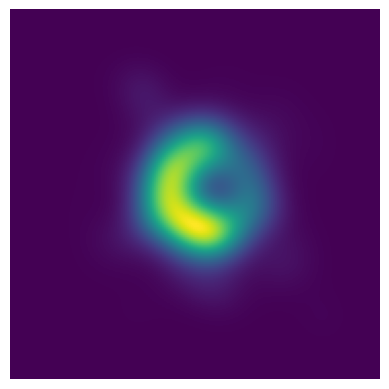

In [6]:
file = open("images/3597_blur_avg.txt","r")
lines = file.readlines()
image = np.empty([180,180])
t = []
for line in lines:
    coord = line.strip().split()
    x = int(float(coord[0]) * 1000000)
    y = int(float(coord[1]) * 1000000)
    z = int(float(coord[2]) * 10000000000)
    image[x+90][y+90] = z
plt.figure()
plt.imshow(image)
plt.axis('off')

And here is what the data looks like in the Fourier Domain

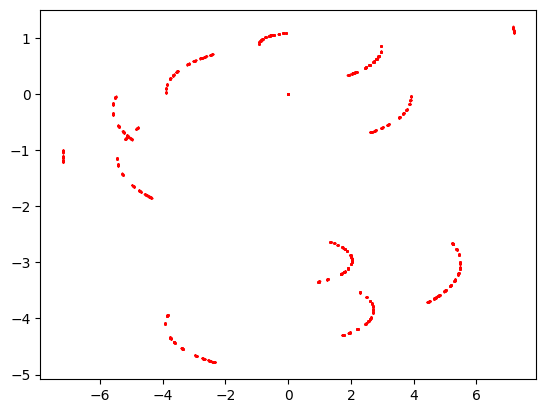

In [11]:
FOV=180*u.uas.to(u.rad)
kx_1 = (1)/FOV

x,y = [], []
for data in data_list:
    x.append((data.u/kx_1))
    y.append(data.v/kx_1)

ft_image = np.fft.fftshift(np.fft.fft2(image))
plt.xlabel("u")
plt.ylabel("v")
plt.figure()

plt.scatter(x,y,color="red",s=0.1)